This notebook cleans and prepares our CLV data for feature engineering:

+ validating data types

+ resolving time-based features into numeric form

+ handling imbalanced and outliers

+ ensuring no data leakage


In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet("../data/processed/clv_table_data.parquet")

__One major step we have to do is to convert the days columns (`recency` and `customer_age`) taht were in timedelta to integer__

__This is because pandas automatically converts them to nanoseconds if not handled__

__We'll convert it to days, keeping it as meaningful float datatype to represent hour-level precision__

In [78]:
df["purchase_recency"] = pd.to_timedelta(df["recency"], unit="ns").dt.total_seconds() / 86400
df["customer_age"] = pd.to_timedelta(df["customer_age"], unit="ns").dt.total_seconds() / 86400

df.head()

,customer_id,transaction_count,promo_code_used,quantity,total_spent,avg_order_value,first_purchase_date,last_purchase_date,recency,customer_age,payment_method_count,future_spend,purchase_recency
0,3,12,11,25,20243575.0,963979.761905,2021-01-10 07:56:16.844494,2021-12-12 12:35:12.844494,1682687155506000,355.669249,2,2998828.0,19.475546
1,8,5,1,9,3237281.0,539546.833333,2021-02-13 09:47:39.656991,2021-12-14 20:12:39.656991,1482440343009000,321.591902,2,1521320.0,17.157874
2,9,3,0,5,3206995.0,641399.000000,2021-06-27 01:51:48.421034,2021-11-08 04:42:31.421034,4648648578966000,187.922356,2,906635.0,53.803803
3,15,1,1,1,127423.0,127423.000000,2021-06-12 04:30:42.105040,2021-06-12 04:30:42.105040,17522957894960000,202.812013,1,73320.0,202.812013
4,18,7,11,16,12794750.0,913910.714286,2021-02-01 17:46:18.010289,2021-11-29 19:50:58.010289,2779741989711000,333.259514,2,1980302.0,32.172940


__Moving `total_spent` next to `future_spend` just to give that sense of comparison for each customer__

In [79]:
col = df.pop("total_spent")
df.insert(10, "total_spent", col)


In [80]:
df.head()

,customer_id,transaction_count,promo_code_used,quantity,avg_order_value,first_purchase_date,last_purchase_date,recency,customer_age,payment_method_count,total_spent,future_spend,purchase_recency
0,3,12,11,25,963979.761905,2021-01-10 07:56:16.844494,2021-12-12 12:35:12.844494,1682687155506000,355.669249,2,20243575.0,2998828.0,19.475546
1,8,5,1,9,539546.833333,2021-02-13 09:47:39.656991,2021-12-14 20:12:39.656991,1482440343009000,321.591902,2,3237281.0,1521320.0,17.157874
2,9,3,0,5,641399.000000,2021-06-27 01:51:48.421034,2021-11-08 04:42:31.421034,4648648578966000,187.922356,2,3206995.0,906635.0,53.803803
3,15,1,1,1,127423.000000,2021-06-12 04:30:42.105040,2021-06-12 04:30:42.105040,17522957894960000,202.812013,1,127423.0,73320.0,202.812013
4,18,7,11,16,913910.714286,2021-02-01 17:46:18.010289,2021-11-29 19:50:58.010289,2779741989711000,333.259514,2,12794750.0,1980302.0,32.172940


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36086 entries, 0 to 36085
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           36086 non-null  int64         
 1   transaction_count     36086 non-null  int64         
 2   promo_code_used       36086 non-null  int64         
 3   quantity              36086 non-null  int64         
 4   avg_order_value       36086 non-null  float64       
 5   first_purchase_date   36086 non-null  datetime64[ns]
 6   last_purchase_date    36086 non-null  datetime64[ns]
 7   recency               36086 non-null  int64         
 8   customer_age          36086 non-null  float64       
 9   payment_method_count  36086 non-null  int64         
 10  total_spent           36086 non-null  float64       
 11  future_spend          36086 non-null  float64       
 12  purchase_recency      36086 non-null  float64       
dtypes: datetime64[ns

__We'll start by cleaning up how purchase date is shown__

In [82]:

df["first_purchase_date"] = pd.to_datetime(df["first_purchase_date"].dt.strftime("%Y-%m-%d %H:%M"))
df["last_purchase_date"] = pd.to_datetime(df["last_purchase_date"].dt.strftime("%Y-%m-%d %H:%M"))


__`customer_age` can be misleading so we'll rename it to `customer_tenure` to represent how long since that customer first purchased from us (from the observation window)__

__We'll also rename `promo_code_used`. It's easy to think this could be a categorical feature meanwhile it's not__

In [83]:
df.rename(columns={"customer_age": "customer_tenure"}, inplace=True)
df.rename(columns={"promo_code_used": "promo_usage_count"}, inplace=True)

__Now it'a just formatted to the hour__

In [84]:
df[["first_purchase_date", "last_purchase_date"]]

,first_purchase_date,last_purchase_date
0,2021-01-10 07:56:00,2021-12-12 12:35:00
1,2021-02-13 09:47:00,2021-12-14 20:12:00
2,2021-06-27 01:51:00,2021-11-08 04:42:00
3,2021-06-12 04:30:00,2021-06-12 04:30:00
4,2021-02-01 17:46:00,2021-11-29 19:50:00
...,...,...
36081,2021-04-05 05:27:00,2021-12-03 05:23:00
36082,2021-02-21 11:40:00,2021-08-15 15:19:00
36083,2021-01-06 00:23:00,2021-11-17 07:01:00
36084,2021-01-10 13:11:00,2021-12-24 20:46:00


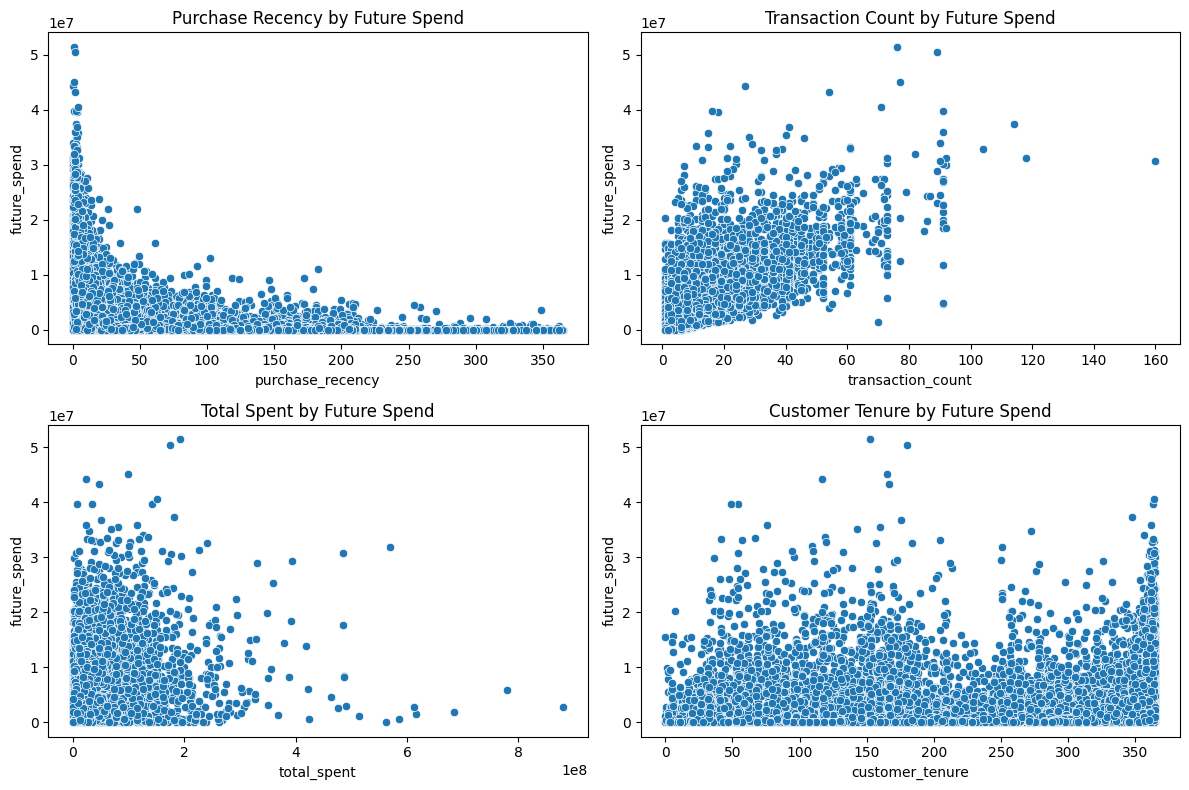

In [85]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.scatterplot(x=df["purchase_recency"], y=df["future_spend"], ax=axes[0, 0])
axes[0, 0].set_title("Purchase Recency by Future Spend")

sns.scatterplot(x=df["transaction_count"], y=df["future_spend"], ax=axes[0, 1])
axes[0, 1].set_title("Transaction Count by Future Spend")

sns.scatterplot(x=df["total_spent"], y=df["future_spend"], ax=axes[1, 0])
axes[1, 0].set_title("Total Spent by Future Spend")

sns.scatterplot(x=df["customer_tenure"], y=df["future_spend"], ax=axes[1, 1])
axes[1, 1].set_title("Customer Tenure by Future Spend")

plt.tight_layout()
plt.show()

__About 25% of customers generated no future revenue for the business__

In [86]:
df.query('future_spend == 0').count()   # 9594 generated us no revenue
df.query('future_spend > 0').count()   # 26492 generated us revenue

customer_id             26492
transaction_count       26492
promo_usage_count       26492
quantity                26492
avg_order_value         26492
first_purchase_date     26492
last_purchase_date      26492
recency                 26492
customer_tenure         26492
payment_method_count    26492
total_spent             26492
future_spend            26492
purchase_recency        26492
dtype: int64

In [87]:
df.sample(5)

,customer_id,transaction_count,promo_usage_count,quantity,avg_order_value,first_purchase_date,last_purchase_date,recency,customer_tenure,payment_method_count,total_spent,future_spend,purchase_recency
9312,25494,1,1,1,2.690380e+05,2021-12-26 01:41:00,2021-12-26 01:41:00,512291999843000,5.929306,1,269038.0,236170.0,5.929306
497,1326,2,1,4,6.903130e+05,2021-05-18 08:52:00,2021-12-25 12:48:00,558704821580000,227.629894,2,2761252.0,0.0,6.466491
20351,56099,3,1,8,1.074820e+06,2021-03-02 15:12:00,2021-09-24 18:24:00,8487354233562000,304.366484,1,7523743.0,425182.0,98.233267
17578,48423,17,13,38,9.301629e+05,2021-01-10 20:29:00,2021-12-28 21:03:00,269817931573000,355.146481,4,20463583.0,4728772.0,3.122893
8986,24615,2,1,2,2.931635e+05,2021-03-19 19:28:00,2021-09-03 20:42:00,10293427844900000,287.188517,1,586327.0,289286.0,119.136896


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36086 entries, 0 to 36085
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           36086 non-null  int64         
 1   transaction_count     36086 non-null  int64         
 2   promo_usage_count     36086 non-null  int64         
 3   quantity              36086 non-null  int64         
 4   avg_order_value       36086 non-null  float64       
 5   first_purchase_date   36086 non-null  datetime64[ns]
 6   last_purchase_date    36086 non-null  datetime64[ns]
 7   recency               36086 non-null  int64         
 8   customer_tenure       36086 non-null  float64       
 9   payment_method_count  36086 non-null  int64         
 10  total_spent           36086 non-null  float64       
 11  future_spend          36086 non-null  float64       
 12  purchase_recency      36086 non-null  float64       
dtypes: datetime64[ns

__We can drop the former `recency` and `customer_age` feature__

In [89]:
df.to_parquet("../data/processed/cleaned_clv_data.parquet", index=False)